In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import seaborn as sns 

print('seaborn: ', sns.__version__)

seaborn:  0.11.2


In [2]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("data/kddcup.data.corrected", sep=",", names=columns, index_col=None)


In [3]:
# Filter to only 'http' attacks
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)


In [4]:
df['label'] = df['label'].apply(lambda x: 0 if x=='normal.' else 1)
df['label'].value_counts()

label
0    619046
1      4045
Name: count, dtype: int64

In [5]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))

encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder 


In [6]:
# Check the variables with highest correlation with 'label'
df2 = df.copy()
label_corr = df2.corr()['label']

# Filter out anything that has null entry or is not weakly correlated
train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > 0.2)]
train_cols = list(train_cols[:-1].index)
train_cols

['src_bytes',
 'hot',
 'num_compromised',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate']

In [7]:
labels = df2['label']
# Conduct a train-test split    
x_train, x_test, y_train, y_test = train_test_split(df2[train_cols].values, labels.values, test_size = 0.15, random_state = 42)


In [8]:
# Additional split of training dataset to create validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [9]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(423701, 13)
y_train:(423701,)

x_val:(105926, 13)
y_val:(105926,)

x_test:(93464, 13)
y_test:(93464,)


In [23]:
import torch

print(f"Torch version: {torch.__version__}")
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset

Torch version: 1.9.0+cu111


In [11]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).type(torch.long)

x_val = torch.Tensor(x_val)
y_val = torch.Tensor(y_val).type(torch.long)

x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test).type(torch.long)

train_set = TensorDataset(x_train, y_train)
val_set = TensorDataset(x_val, y_val)
test_set = TensorDataset(x_test, y_test)

train_dataloader = DataLoader(train_set, batch_size = 128)
val_dataloader = DataLoader(val_set, batch_size = 128)
test_dataloader = DataLoader(test_set, batch_size = 128)


In [14]:

class model(torch.nn.Module):
    def __init__(self):
        super().__init__()
            
        self.h1 = Linear(13, 26)
        self.h2 = Linear(26, 26)
        self.h3 = Linear(26, 26)
        self.h4 = Linear(26, 6)
        self.h5 = Linear(6, 2)
    
    def forward(self, x):
        x = self.h1(x).relu()
        x = self.h2(x).relu()
        x = self.h3(x).relu()
        x = self.h4(x).relu()
        x = self.h5(x)
        
        return x 
    
mlp = model()

In [15]:
optim = Adam(mlp.parameters(), lr=1e-3)
criterion = CrossEntropyLoss() 

In [17]:
epochs = 20
tolerance = 1e-3
lambda_ = 1e-5
best_loss = np.inf
patience = 5
early_stop_counter = 0
best_save_path = 'ch5_mlp_pytorch_best.pt'

mlp.cuda()
for e in range(epochs):
    
    for i, (data, labels) in enumerate(train_dataloader):
        optim.zero_grad()
        
        data = data.cuda()
        labels = labels.cuda()
        
        preds = mlp.forward(data)
        
        loss = criterion(preds, labels)
        
        l2_norm = sum(p.pow(2.0).sum() for p in mlp.parameters())
        loss = loss + lambda_ * l2_norm
        
        loss.backward()
        
        optim.step()
        
        predictions = preds.detach().cpu().numpy().argmax(axis=1)
        y_true = labels.detach().cpu().numpy()
        
        acc = np.mean(y_true == predictions)
        
        print(f'\rEpoch {e} / {epochs}: {i}/{len(train_dataloader)} | loss: {loss.item()} acc: {acc}'.ljust(200, ' '), end= '')
        
        
    # Validation
    
    with torch.no_grad():
        hold = np.array([])
        loss_hold = []
        for i, (data, labels) in enumerate(val_dataloader):

            data = data.cuda()
            labels = labels.cuda()

            preds = mlp.forward(data)

            loss = criterion(preds, labels)
            l2_norm = sum(p.pow(2.0).sum() for p in mlp.parameters())
            loss = loss + lambda_ * l2_norm

            predictions = preds.detach().cpu().numpy().argmax(axis=1)
            y_true = labels.detach().cpu().numpy()
            
            hold = np.concatenate((y_true == predictions, hold))
            loss_hold.append(loss.item())
            
        val_acc = np.mean(hold)
        val_loss = np.mean(loss_hold)
        print(f'\rEpoch {e} / {epochs}: {i}/{len(val_dataloader)} | loss: {loss.item()} acc: {acc} val_loss: {val_loss} val_acc: {val_acc}'.ljust(200, ' '), end= '\n')
    
    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
        
        torch.save(mlp.state_dict(), best_save_path)
        
    elif abs(best_loss - val_loss) <= tolerance:
        pass
    else:
        early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print(f'\rEpoch {e} / {epochs}: {i}/{len(val_dataloader)} | loss: {loss.item()} acc: {acc} val_loss: {val_loss} val_acc: {val_acc} Early Stopping'.ljust(200, ' '), end= '\n')
            mlp.load_state_dict(torch.load(best_save_path))
            break 
                   
                   

Epoch 0 / 20: 827/828 | loss: 0.0007202776032499969 acc: 1.0 val_loss: 0.003406143917886041 val_acc: 0.9998583917074184                                                                                
Epoch 1 / 20: 827/828 | loss: 0.00105832249391824 acc: 1.0 val_loss: 0.002974088849828259 val_acc: 0.9998678322602571                                                                                  
Epoch 2 / 20: 827/828 | loss: 0.000773684645537287 acc: 1.0 val_loss: 0.002741797632033878 val_acc: 0.9998772728130959                                                                                 
Epoch 3 / 20: 827/828 | loss: 0.0006962550687603652 acc: 1.0 val_loss: 0.002940932255303532 val_acc: 0.9998961539187735                                                                                
Epoch 4 / 20: 827/828 | loss: 0.0007242353749461472 acc: 1.0 val_loss: 0.002827661038488307 val_acc: 0.9998961539187735                                                                                


In [18]:
with torch.no_grad():
    hold = np.array([])
    loss_hold = []
    for i, (data, labels) in enumerate(test_dataloader):

        data = data.cuda()
        labels = labels.cuda()

        preds = mlp.forward(data)

        loss = criterion(preds, labels)

        predictions = preds.detach().cpu().numpy().argmax(axis=1)
        y_true = labels.detach().cpu().numpy()

        hold = np.concatenate((y_true == predictions, hold))
        loss_hold.append(loss.item())
        print(f'\rEvaluating {i}/{len(test_dataloader)} | loss: {loss.item()} acc: {np.mean(y_true==predictions)}'.ljust(200, ' '), end= '')
        
    test_acc = np.mean(hold)
    test_loss = np.mean(loss_hold)
    print(f'\rEvaluating {i}/{len(test_dataloader)} | loss: {test_loss} acc: {test_acc}'.ljust(200, ' '), end= '')



Evaluating 730/731 | loss: 0.00024468251649472625 acc: 0.9999679020799452                                                                                                                              

In [19]:
preds = mlp.forward(x_test.cuda())

# Detach from Cuda and derive the label predictions from the probability scores
y_preds = preds.detach().cpu().numpy().argmax(axis=1)

# Original labels became a tensor, so convert back to a numpy array
y_true = y_test.numpy()

# Compute precision, recall, f1 scores
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)
f1_measure = f1_score(y_true, y_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1_measure}")

Precision: 1.0
Recall: 0.9947275922671354
F1-Measure: 0.9973568281938325


In [24]:
roc_auc_score(y_true, y_preds)

0.9973637961335677

Text(33.0, 0.5, 'True Label')

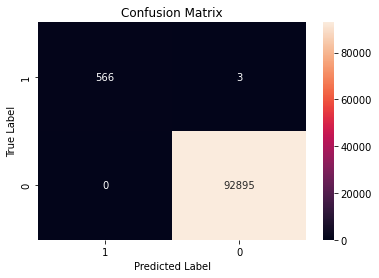

In [25]:
cm = confusion_matrix(y_true, y_preds)
plt.title("Confusion Matrix")
ax = sns.heatmap(cm, annot=True, fmt='0.0f')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')